In [591]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%autosave 300

import warnings
warnings.filterwarnings('default')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.dummy import DummyRegressor
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.neural_network import MLPRegressor
import xgboost as xgb



Autosaving every 300 seconds


In [642]:
new_list

['DistrictId',
 'Rooms',
 'Square',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_3_A',
 'Shops_2_A',
 'KitchenSquare_0',
 'KitchenSquare_1']

In [602]:
df = pd.read_csv('train.csv')
df = pd.get_dummies(df)
all_columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 
               'Ecology_1', 'Social_1', 'Social_2','Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
               'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']

working_list = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor','HouseYear', 'Ecology_1', 
                'Social_1', 'Social_2', 'Social_3','Helthcare_2', 'Shops_1', 'Ecology_2_A', 'Ecology_3_A', 'Shops_2_A']

new_list = ['DistrictId','Rooms','Square','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3',
            'Helthcare_2','Shops_1','Ecology_2_A','Ecology_3_A','Shops_2_A','KitchenSquare_0','KitchenSquare_1']

another_list = ['Rooms','Square','Floor','HouseFloor','Ecology_1','Social_1','Social_2','Social_3',
                'Helthcare_2','Shops_1','Ecology_2_A','Ecology_3_A','Shops_2_A','KitchenSquare_0','KitchenSquare_1',
                'cluster_year_1', 'cluster_year_2', 'cluster_year_3']

### Estimator ###

In [514]:
%%time
def estimator(features, model, cv=3, poly=0,preprocess='none',interaction_only=False,PCA_n=0):
    X = df[features]
    y = df['Price']
    preprocess_dict = {"standard" : preprocessing.StandardScaler(), "normal" : preprocessing.Normalizer(), 
                       'minmax' : preprocessing.MinMaxScaler(), 'maxabs' : preprocessing.MaxAbsScaler(), 
                       'robust' : preprocessing.RobustScaler(),'none': 'passthrough' }
    dimension_r = PCA(n_components = PCA_n) if PCA_n else 'passthrough'
    polynomial = PolynomialFeatures(degree=poly,interaction_only=interaction_only) if poly else 'passthrough'
    pipeline = make_pipeline(polynomial,preprocess_dict[preprocess],dimension_r,model)
    scores = cross_val_score(pipeline, X, y, cv=cv)
    return scores.mean()

def custom_estimator(features, model, transform=[], poly=0,preprocess='none',interaction_only=False,PCA_n=0,train_transform = False):
    df_train=[df.loc[0:6666,:],df.loc[3333:,:],df.loc[0:3332,:].append(df.loc[6666:,:])]
    df_test=[df.loc[6667:,:],df.loc[0:3332,:],df.loc[3333:6665,:]]

    score = []
    for i in range (0,3):
        for func in transform:
            if train_transform:
                df_train[i],transf = func(df_train[i].copy(),return_t=True)
                df_test[i] = func(df_test[i].copy(),transf,t=True)
            else:
                df_train[i] = func(df_train[i].copy())
                df_test[i] = func(df_test[i].copy())

        X = df_train[i][features]
        y = df_train[i]['Price']
        X_test = df_test[i][features]
        y_test = df_test[i]['Price']
        
        preprocess_dict = {"standard" : preprocessing.StandardScaler(), "normal" : preprocessing.Normalizer(), 
                           'minmax' : preprocessing.MinMaxScaler(), 'maxabs' : preprocessing.MaxAbsScaler(), 
                           'robust' : preprocessing.RobustScaler(),'none': 'passthrough' }
        dimension_r = PCA(n_components = PCA_n) if PCA_n else 'passthrough'
        polynomial = PolynomialFeatures(degree=poly,interaction_only=interaction_only) if poly else 'passthrough'
        pipeline = make_pipeline(polynomial,preprocess_dict[preprocess],dimension_r,model)
        pipeline.fit(X,y)
        score.append(pipeline.score(X_test,y_test))
    return sum(score)/len(score)


model = RandomForestRegressor(n_estimators=100,random_state=0,n_jobs=8,max_depth=20,max_features=0.3,\
                              max_leaf_nodes=2400,warm_start=False)
#display(estimator(working_list,model,preprocess='standard'))
valid = custom_estimator(working_list,model,preprocess='standard')
print(valid)

0.7363418229083086
CPU times: user 6.07 s, sys: 79.2 ms, total: 6.15 s
Wall time: 1.5 s


### Rooms ###

In [212]:
price_mean_by_rooms=df.loc[(df['Rooms'] < 6) & (df['Rooms'] != 0)].groupby(['Rooms'],as_index=False).agg({'Price':'mean'}).\
                        rename(columns={'Price':'g_price'})
display(price_mean_by_rooms)

,Rooms,g_price
0,1.0,159850.800729
1,2.0,215256.306416
2,3.0,289337.962452
3,4.0,383251.100956
4,5.0,410431.605679


In [385]:
def rooms_t(dataframe,return_t=False,t=False):
    price_mean_by_rooms=dataframe.loc[(dataframe['Rooms'] < 6) & (dataframe['Rooms'] != 0)].groupby(['Rooms'],as_index=False).agg({'Price':'mean'}).\
                        rename(columns={'Price':'g_price'})
    #display(price_mean_by_rooms)
    #display(dataframe.loc[(dataframe['Rooms'] > 5) | (dataframe['Rooms'] == 0)])
    saved = dataframe.loc[(df['Rooms'] > 5) | (dataframe['Rooms'] == 0)].index
    for index, row in dataframe.loc[(dataframe['Rooms'] > 5) | (dataframe['Rooms'] == 0)].iterrows():
        min_array = []
        for i,r in price_mean_by_rooms.iterrows():
            min_array.append(((row['Price'] - r['g_price']) ** 2,r['Rooms']))
        dataframe.loc[index,'Rooms'] = sorted(min_array)[0][1]
    #display(dataframe.loc[saved,:])
    return dataframe

result = custom_estimator(working_list,model,transform=[rooms_t],preprocess='standard')
print(f'{result},{result - valid:.8f}')

0.7361684381188421,-0.00017338


In [516]:
def rooms_t2(dataframe,gr=None,return_t=False,t=False):
    if t:
        group = gr
    else:
        group=dataframe.loc[(dataframe['Rooms'] < 6) & (dataframe['Rooms'] != 0)].\
                    groupby(['Rooms'],as_index=False).agg({'Square':'mean'})

    for index, row in dataframe.loc[(dataframe['Rooms'] > 5) | (dataframe['Rooms'] == 0)].iterrows():
        min_array = []
        for i,r in group.iterrows():
            min_array.append(((row['Square'] - r['Square']) ** 2,r['Rooms']))
        dataframe.loc[index,'Rooms'] = sorted(min_array)[0][1]
    return (dataframe,group) if return_t else dataframe

result = custom_estimator(working_list,model,transform=[rooms_t2],preprocess='standard')
print(f'{result},{result - valid:.8f}')

0.7362400134682919,-0.00010181


In [438]:
result = custom_estimator(working_list,model,transform=[rooms_t2],preprocess='standard',train_transform=True)
print(f'{result},{result - valid:.8f}')

0.736244548045379,-0.00009727


### Square ###

In [234]:
dataframe = df.copy()
rooms_transform2(dataframe)
group=dataframe.loc[(df['Square'] < 276) & (df['Square'] > 18)].\
                    groupby(['Rooms'],as_index=False).agg({'Square':'mean'})
display(group)
display(dataframe.loc[(dataframe['Square'] > 276) | (dataframe['Square'] < 18)])

,Rooms,Square
0,1.0,41.325170
1,2.0,56.520209
2,3.0,77.025391
3,4.0,98.307246
4,5.0,127.921450


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,...,NaN,3,9,412511.088764,0,1,0,1,0,1
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,...,NaN,0,0,107604.269441,0,1,0,1,0,1
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,...,540.0,0,0,137597.601458,0,1,0,1,0,1
1891,13685,0,1.0,17.498542,13.446544,0.0,7,5.0,1961,0.319809,...,2857.0,5,8,88871.750230,0,1,0,1,0,1
3166,15127,150,1.0,17.046188,20.036232,8.0,7,12.0,1982,0.300323,...,NaN,1,9,74222.110465,0,1,0,1,0,1
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,...,NaN,0,1,97560.720383,0,1,0,1,0,1
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,...,2643.0,4,5,369472.403061,0,1,0,1,0,1
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,...,30.0,2,4,187717.242538,0,1,0,1,0,1
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,...,705.0,3,6,90470.430830,0,1,0,1,0,1
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,...,2857.0,5,8,78388.806186,0,1,0,1,0,1


In [517]:
# df.loc[(df['Square'] > 276) | (df['Square'] < 18)]
def square_t(dataframe,gr=None,return_t=False,t=False):
    if t:
        group = gr
    else:
        group = dataframe.loc[(dataframe['Square'] < 276) & (dataframe['Square'] > 18)].\
                groupby(['Rooms'],as_index=False).agg({'Square':'mean'})
    saved = dataframe.loc[(dataframe['Square'] > 276) | (dataframe['Square'] < 18)].index
    for index, row in dataframe.loc[(dataframe['Square'] > 276) | (dataframe['Square'] < 18)].iterrows():
        min_array = []
        for i,r in group.iterrows():
            if row['Rooms']  == r['Rooms']:
                dataframe.loc[index,'Square']=r['Square']
    #display(dataframe.loc[saved,:])
    return (dataframe,group) if return_t else dataframe

result = custom_estimator(working_list,model,transform=[rooms_t2,square_t],preprocess='standard')
print(f'{result},{result - valid:.8f}')


0.7377476763570446,0.00140585


In [518]:
result = custom_estimator(working_list,model,transform=[rooms_t2,square_t],preprocess='standard',train_transform=True)
print(f'{result},{result - valid:.8f}')

0.7377980515752895,0.00145623


### Kitchen ###

In [388]:
def kitchen_t(dataframe):
    dataframe['KitchenRatio'] = np.divide(dataframe['KitchenSquare'],dataframe['Square'])
    group = dataframe.loc[(dataframe['KitchenSquare'] < 250) & (dataframe['KitchenSquare'] > 5 ) & (dataframe['KitchenRatio'] < 0.6)].\
                    groupby(['Rooms'],as_index=False).agg({'KitchenRatio':'mean'})
    data_to_transform = dataframe.\
            loc[(dataframe['KitchenSquare'] > 250) | (dataframe['KitchenSquare'] < 5 ) | (dataframe['KitchenRatio'] > 0.6)]
    saved = data_to_transform.index
    for index, row in data_to_transform.iterrows():
        min_array = []
        for i,r in group.iterrows():
            if row['Rooms']  == r['Rooms']:
                dataframe.loc[index,'KitchenSquare']=row['Square'] * r['KitchenRatio']
    #display(dataframe.loc[saved,:])
    return dataframe

result = custom_estimator(working_list,model,transform=[rooms_t2,square_t,kitchen_t],preprocess='standard')
print(f'{result},{result - valid:.8f}')



0.7356179813965756,-0.00072384


In [519]:
def kitchen_t2(dataframe,gr=None,return_t=False,t=False):
    dataframe['KitchenRatio'] = np.divide(dataframe['KitchenSquare'],dataframe['Square'])
    dataframe.loc[dataframe['KitchenRatio'] < 0.05,'KitchenSquare'] = '0'
    dataframe.loc[(dataframe['KitchenRatio'] >= 0.05) & (dataframe['KitchenRatio'] < 0.17687925), 'KitchenSquare'] = '1'
    dataframe.loc[dataframe['KitchenRatio'] >= 0.17687925,'KitchenSquare'] = '2'
    dataframe = pd.get_dummies(dataframe)
    return (dataframe,group) if return_t else dataframe

result = custom_estimator(new_list,\
                          model,transform=[rooms_t2,square_t,kitchen_t2],preprocess='standard')
print(f'{result},{result - valid:.8f}')

0.7380598004413765,0.00171798


In [520]:
result = custom_estimator(new_list,\
                          model,transform=[rooms_t2,square_t,kitchen_t2],preprocess='standard',train_transform=True)
print(f'{result},{result - valid:.8f}')

0.7382436987672357,0.00190188


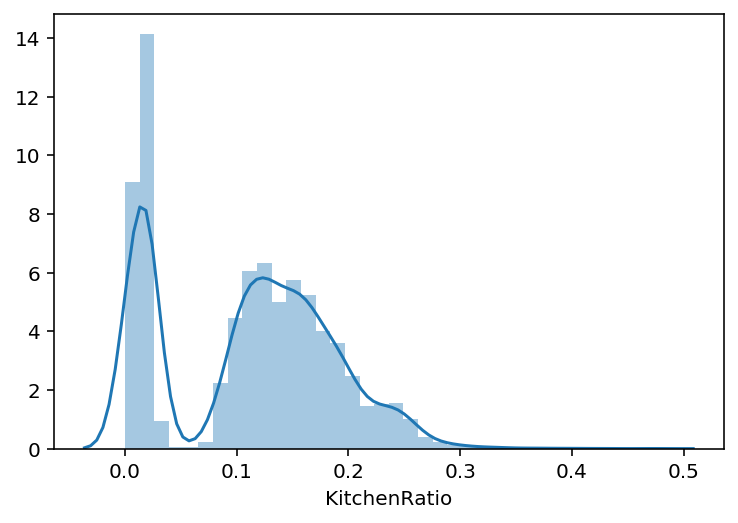

In [307]:
dataframe = df.copy()
rooms_transform2(dataframe)
square_transform(dataframe)
dataframe['KitchenRatio'] = np.divide(dataframe['KitchenSquare'],dataframe['Square'])
sns.distplot(dataframe.loc[dataframe['KitchenRatio'] < 0.6,'KitchenRatio'])

[[0.12661025]
 [0.207004  ]]


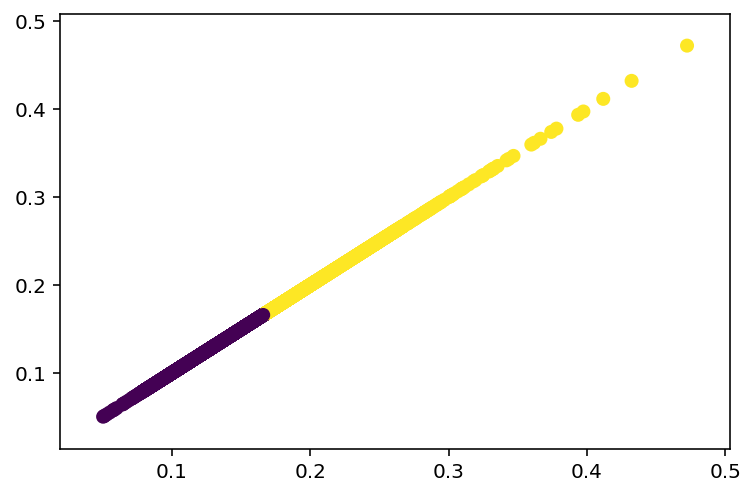

In [329]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter = 100, random_state = 42)
cluster = dataframe.loc[(dataframe['KitchenRatio'] < 0.6) & (dataframe['KitchenRatio'] > 0.05),'KitchenRatio']
labels_train = kmeans.fit_predict(cluster.values.reshape(-1, 1))
plt.scatter(cluster,cluster,c=labels_train)
print(kmeans.cluster_centers_)
cluster.describe()

c = 0.12661025 + 0.050269
c 0.17687925

### Floor ###

In [401]:
def floor_t(dataframe):
    dataframe.loc[dataframe['HouseFloor']  < 1,'HouseFloor'] = dataframe.loc[dataframe['HouseFloor']  < 1,'Floor'] + 2
    dataframe['FloorRatio'] = np.divide(dataframe['Floor'],dataframe['HouseFloor'])
    dataframe.loc[dataframe['FloorRatio']  > 1,'HouseFloor'] = dataframe.loc[dataframe['FloorRatio']  > 1,'Floor'] + 2
    dataframe['FloorDummy'] = '0'
    dataframe.loc[(dataframe['FloorRatio']  > 0.4) & (dataframe['FloorRatio']  < 0.6),'FloorDummy'] = '1'
    dataframe.loc[dataframe['Floor'] == 1,'FloorDummy'] = '2'
    dataframe.loc[dataframe['Floor'] == dataframe['HouseFloor'],'FloorDummy'] = '3'
    dataframe = pd.get_dummies(dataframe)
    return dataframe
new_list2 = new_list.copy()
new_list2.extend(['FloorDummy_1', 'FloorDummy_2', 'FloorDummy_3'])
new_list2.remove('HouseFloor')
new_list2.remove('Floor')


result = custom_estimator(new_list2,\
                          model,transform=[rooms_t2,square_t,kitchen_t2,floor_t],preprocess='standard')
print(f'{result},{result - valid:.8f}')


0.7272698866321168,-0.00907194


### HouseYear and District ###

In [463]:
def hyd_t(dataframe,gr=None,return_t=False,t=False):
    dataframe.loc[dataframe['HouseYear']==20052011,'HouseYear']=2008
    dataframe.loc[dataframe['HouseYear']==4968,'HouseYear']=1968
    scaler=preprocessing.MinMaxScaler()
    scaled=scaler.fit_transform(dataframe.loc[:,['HouseYear','DistrictId']])
    if t:
        dataframe['cluster_year'] = gr.predict(scaled)
    else:
        group=KMeans(n_clusters=5)
        dataframe['cluster_year'] = group.fit_predict(scaled)
    dataframe['cluster_year'] = dataframe['cluster_year'].astype(object)
    dataframe = pd.get_dummies(dataframe)

    return (dataframe,group) if return_t else dataframe
another_list = ['HouseYear','Rooms','Square','Floor','HouseFloor','Ecology_1','Social_1','Social_2','Social_3',
                'Helthcare_2','Shops_1','Ecology_2_A','Ecology_3_A','Shops_2_A','KitchenSquare_0','KitchenSquare_1',
                'cluster_year_0','cluster_year_1', 'cluster_year_2', 'cluster_year_3','cluster_year_4','cluster_year_5']
result = custom_estimator(another_list[0:-2],model,\
                           transform=[rooms_t2,square_t,kitchen_t2,hyd_t],preprocess='standard')
print(f'{result},{result - valid:.8f}')


0.7218892825352184,-0.01445254


In [454]:
result = custom_estimator(another_list,model,\
                          transform=[rooms_transform2,square_transform,kitchen_transform2,hyd_transform],\
                          preprocess='standard',train_transform=True)
print(f'{result},{result - valid:.8f}')

0.7321922350164893,-0.00414959


In [521]:
def district_t(dataframe,gr=None,return_t=False,t=False):
    if t:
        group = gr
    else:
        distr_info=dataframe['DistrictId'].value_counts().reset_index()
        kmeans=KMeans(n_clusters=3)
        distr_info['clustered'] = kmeans.fit_predict(distr_info['DistrictId'].values.reshape(-1, 1))
        group = []
        group.append(set(distr_info.loc[distr_info['clustered'] == 1,'index'].tolist()))
        group.append(set(distr_info.loc[distr_info['clustered'] == 2,'index'].tolist()))
        group.append(set(distr_info.loc[distr_info['clustered'] == 0,'index'].tolist()))
        group = sorted([(len(i),i) for i in group])
        
    dataframe['Dist_cluster'] = '0'
    dataframe.loc[dataframe['DistrictId'].isin(group[0][1]),'Dist_cluster'] = '1'
    dataframe.loc[dataframe['DistrictId'].isin(group[1][1]),'Dist_cluster'] = '2'

    dataframe['Dist_cluster'] = dataframe['Dist_cluster'].astype(object)
    dataframe = pd.get_dummies(dataframe)

    return (dataframe,group) if return_t else dataframe

another_list = ['DistrictId','HouseYear','Rooms','Square','Floor','HouseFloor','Ecology_1','Social_1','Social_2','Social_3',
                'Helthcare_2','Shops_1','Ecology_2_A','Ecology_3_A','Shops_2_A','KitchenSquare_0','KitchenSquare_1',
                'Dist_cluster_0','Dist_cluster_1']
result = custom_estimator(another_list,model,\
                           transform=[rooms_transform2,square_transform,kitchen_transform2,district_t],preprocess='standard')
print(f'{result},{result - valid:.8f}')

0.7347615112842684,-0.00158031


In [513]:
model = RandomForestRegressor(n_estimators=100,random_state=0,n_jobs=8,max_depth=18,max_features=5,\
                              max_leaf_nodes=2400,warm_start=False)

result = custom_estimator(another_list,model,\
                           transform=[rooms_transform2,square_transform,kitchen_transform2,district_t],preprocess='standard',train_transform=True)
print(f'{result},{result - valid:.8f}')



0.737118815567437,0.00077699


### LifeSquare ###

In [545]:
# df.loc[(df['Square'] > 276) | (df['Square'] < 18)]

def life_square_t(dataframe,gr=None,return_t=False,t=False):
    if t:
        group = gr
    else:
        group = dataframe.loc[(dataframe['LifeSquare'].notnull()) & (dataframe['LifeSquare'] > 10)].\
                groupby(['Rooms'],as_index=False).agg({'LifeSquare':'mean'})
    to_transform = dataframe.loc[(dataframe['LifeSquare'].isnull()) | (dataframe['LifeSquare'] < 10)]
    saved = to_transform.index
    for index, row in to_transform.iterrows():
        min_array = []
        for i,r in group.iterrows():
            if row['Rooms']  == r['Rooms']:
                dataframe.loc[index,'LifeSquare']=r['LifeSquare']
    return (dataframe,group) if return_t else dataframe

new_list = ['LifeSquare','DistrictId','Rooms','Square','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3',
            'Helthcare_2','Shops_1','Ecology_2_A','Ecology_3_A','Shops_2_A','KitchenSquare_0','KitchenSquare_1']
result = custom_estimator(new_list,\
                          model,transform=[rooms_t2,square_t,kitchen_t2,life_square_t],preprocess='standard',train_transform=True)
print(f'{result},{result - valid:.8f}')


0.7337754875096678,-0.00256634


### Healthcare ###

In [549]:
def healthcare_t(dataframe,gr=None,return_t=False,t=False):
    dataframe['Healthcare_d'] = 0
    dataframe.loc[dataframe['Healthcare_1'].notnull(), 'Healthcare_d'] = 1
    return (dataframe,group) if return_t else dataframe

new_list = ['DistrictId','Rooms','Square','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3',
            'Healthcare_d','Helthcare_2','Shops_1','Ecology_2_A','Ecology_3_A','Shops_2_A','KitchenSquare_0','KitchenSquare_1']
result = custom_estimator(new_list,\
                          model,transform=[rooms_t2,square_t,kitchen_t2,healthcare_t],preprocess='standard',train_transform=True)
print(f'{result},{result - valid:.8f}')




0.7365011560828704,0.00015933


In [537]:
dataframe.loc[(dataframe['LifeSquare'].notnull()) & (dataframe['LifeSquare'] > 10)].\
                groupby(['Rooms'],as_index=False).agg({'LifeSquare':'mean'})

,Rooms,LifeSquare
0,1.0,25.909284
1,2.0,36.790026
2,3.0,55.821087
3,4.0,67.179958
4,5.0,98.809890


### Machine learning ### 

    0 	0.738447 	5 	18 	2000
 	0.738447 	5 	18 	2000
    0 	0.738618 	5 	18 	1800 	4
    0.738656 	5 	18 	1600 	4
    0 	0.738665 	5 	18 	1400 	4
    0.738671 	5 	18 	1460 	4

In [572]:
%%time
result_array = []
for max_features in [7,10,15]:
    for max_depth in range(22,30,2):
        for max_leaf_nodes in range(2000,3200,400):
                for min_samples_split in range(5,6,1):
                        model = ExtraTreesRegressor(n_estimators=100,random_state=0,n_jobs=8,max_depth=max_depth,\
                                                      max_features=max_features, max_leaf_nodes=max_leaf_nodes,\
                                                      min_samples_split = min_samples_split)
                        tup = (custom_estimator(new_list,\
                              model,transform=[rooms_t2,square_t,kitchen_t2],preprocess='standard',train_transform=True)\
                        ,max_features,max_depth,max_leaf_nodes,min_samples_split)
                        result_array.append(tup)
columns = ['R','maxfeatures','max_depth','max_leaf_nodes','min_samples_split']
result_array = sorted(result_array,reverse=True)
display(pd.DataFrame(data = [list(i) for i in result_array],columns = columns))


,R,maxfeatures,max_depth,max_leaf_nodes,min_samples_split
0,0.729739,15,24,2000,5
1,0.729646,15,22,2000,5
2,0.729557,15,24,2400,5
3,0.729438,15,24,2800,5
4,0.729391,15,22,2400,5
5,0.729384,15,28,2000,5
6,0.729365,15,26,2000,5
7,0.729319,15,22,2800,5
8,0.729103,15,26,2400,5
9,0.729100,15,28,2400,5


CPU times: user 3min 34s, sys: 2.65 s, total: 3min 36s
Wall time: 1min 2s


In [560]:
model2 = ExtraTreesRegressor(n_estimators=100,random_state=0,n_jobs=8,max_depth=18,max_features=5,\
                              max_leaf_nodes=2000,warm_start=False)
custom_estimator(new_list,\
                          model2,transform=[rooms_t2,square_t,kitchen_t2],preprocess='standard',train_transform=True)

0.7384467559310366

In [603]:
xgboost = xgb.XGBRegressor(objective="reg:squarederror", random_state=42,n_jobs=8,\
                                                 max_depth=8,gamma=100,colsample_bylevel=0.25,
                                                colsample_bytree=0.75,
                                                colsample_bynode=0.25)
display(xgboost)
display(custom_estimator(new_list,\
                          xgboost,transform=[rooms_t2,square_t,kitchen_t2],preprocess='standard',train_transform=True))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.25,
             colsample_bynode=0.25, colsample_bytree=0.75, gamma=100,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=8, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

0.7352996630797568

 	R 	max_depth 	gamma 	colsample_bylevel 	colsample_bytree 	colsample_bynode
    0 	0.746406 	8 	100 	0.25 	0.75 	0.75
    0 	0.747066 	8 	100 	0.35 	0.65 	0.85
    0   0.747066 	8 	200 	0.35 	0.65 	0.95
    0 	0.748217 	8 	900000 	0.35 	0.65 	0.95
    R 	max_depth 	gamma 	learning_rate 	colsample_bylevel 	colsample_bytree 	colsample_bynode
    0 	0.748527 	8 	1000000 	0.090 	0.35 	0.65 	0.95
    R 	colsample_bytree 	colsample_bylevel 	colsample_bynode
    0 	0.748572 	70 	36 	99

In [643]:
%%time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

xgboost = xgb.XGBRegressor(objective="reg:squarederror", random_state=42,n_jobs=8,learning_rate=0.09,\
                            colsample_bytree=0.70,colsample_bylevel=0.36,colsample_bynode=0.99,\
                            max_depth=8,gamma=0.995*10 ** 8,n_estimators=100)
display(xgboost)
xvalid = custom_estimator(new_list,\
                          xgboost,transform=[rooms_t2,square_t,kitchen_t2],preprocess='standard',train_transform=True)
print(xvalid)
# result_array = []
# for colsample_bytree in [0.25,0.5,0.75]:
#     for colsample_bylevel in [0.25,0.5,0.75]:
#         for colsample_bynode in [0.25,0.5,0.75]:
#             model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42,n_jobs=8,learning_rate=0.09,\
#                             colsample_bytree=colsample_bytree,colsample_bylevel=colsample_bytree,colsample_bynode=colsample_bynode,\
#                             max_depth=8,gamma=0.995*10 ** 6,n_estimators=1000)
#             tup = (custom_estimator(new_list,\
#                   model,transform=[rooms_t2,square_t,kitchen_t2],preprocess='standard',train_transform=True),\
#             colsample_bytree,colsample_bylevel,colsample_bynode)
#             result_array.append(tup)
# columns = ['R','colsample_bytree','colsample_bylevel','colsample_bynode']
# result_array = sorted(result_array,reverse=True)
# display(pd.DataFrame(data = [list(i) for i in result_array],columns = columns))


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.36,
             colsample_bynode=0.99, colsample_bytree=0.7, gamma=99500000.0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=8, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

0.7485715263811423
CPU times: user 5.92 s, sys: 31.9 ms, total: 5.96 s
Wall time: 1.2 s


### Predictor ###

In [689]:
df_train=[df.loc[0:6666,:],df.loc[3333:,:],df.loc[0:3332,:].append(df.loc[6666:,:])]
df_test=[df.loc[6667:,:],df.loc[0:3332,:],df.loc[3333:6665,:]]

xgboost = xgb.XGBRegressor(objective="reg:squarederror", random_state=42,n_jobs=8,learning_rate=0.09,\
                            colsample_bytree=0.70,colsample_bylevel=0.36,colsample_bynode=0.99,\
                            max_depth=8,gamma=0.995*10 ** 8,n_estimators=100)

res = []
for i in range(0,3):
    res.append(predictor(df_train[i],df_test[i],new_list,\
                         xgboost,transform=[rooms_t2,square_t,kitchen_t2],preprocess='standard',train_transform=True))
r2 = []
for i in range(0,3):
    r2.append(r2_score(df_test[i]['Price'],res[i]['Price_p']))
sum(r2)/len(r2)

0.7485715263811423

In [692]:
def predictor(df_train,df_test,features, model, transform=[], poly=0,preprocess='none',interaction_only=False,PCA_n=0,train_transform = False):
#     df_train=pd.read_csv('train.csv')
#     df_test=pd.read_csv('test.csv')

    score = []
    for func in transform:
        if train_transform:
            df_train,transf = func(df_train.copy(),return_t=True)
            df_test = func(df_test.copy(),transf,t=True)
        else:
            df_train = func(df_train.copy())
            df_test = func(df_test.copy())

    X = df_train[features]
    y = df_train['Price']
    X_test = df_test[features]

    preprocess_dict = {"standard" : preprocessing.StandardScaler(), "normal" : preprocessing.Normalizer(), 
                       'minmax' : preprocessing.MinMaxScaler(), 'maxabs' : preprocessing.MaxAbsScaler(), 
                       'robust' : preprocessing.RobustScaler(),'none': 'passthrough' }
    dimension_r = PCA(n_components = PCA_n) if PCA_n else 'passthrough'
    polynomial = PolynomialFeatures(degree=poly,interaction_only=interaction_only) if poly else 'passthrough'
    pipeline = make_pipeline(polynomial,preprocess_dict[preprocess],dimension_r,model)
    pipeline.fit(X,y)
    df_test['Price'] = pipeline.predict(X_test) #### CHANGE
    return df_test

In [694]:
out = predictor(pd.read_csv('train.csv'),pd.read_csv('test.csv'),new_list,\
                         xgboost,transform=[rooms_t2,square_t,kitchen_t2],preprocess='standard',train_transform=True)
out.loc[:,['Id','Price']].to_csv('Serebryanskiy_predictions.csv',index=None)

In [36]:
df.to_pickle('train_clean.pkl')